
# Contador de copas arboles 


Esta notebook sirve para ejecutar el conteo de arboles de imagenes con falso color, asegurarse que esta corriendo en gpu  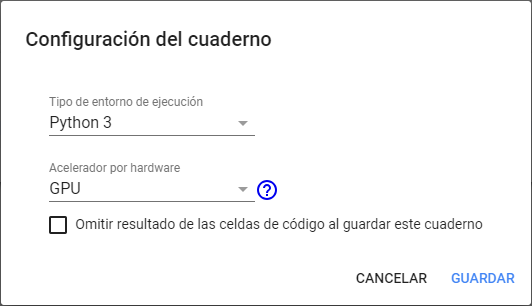

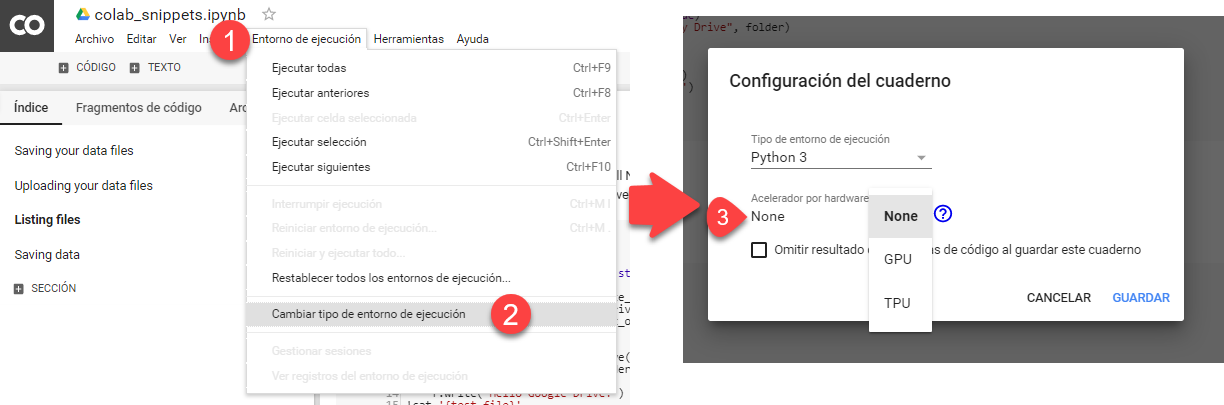# Instalacion de librerias 

In [ ]:
#@title 1️⃣: Pre-Instalacion { vertical-output: true, display-mode: "form" }

!pip install -U torch sahi yolov5 rasterio pyproj simplekml

     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 819 kB 15.1 MB/s 
     |████████████████████████████████| 19.3 MB 130 kB/s 
     |████████████████████████████████| 6.6 MB 55.2 MB/s 
     |████████████████████████████████| 65 kB 4.3 MB/s 
     |████████████████████████████████| 49.9 MB 28 kB/s 
     |████████████████████████████████| 3.0 MB 24.2 MB/s 
     |████████████████████████████████| 636 kB 75.5 MB/s 
     |████████████████████████████████| 87 kB 8.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=9ac845cfd5599ed81a1bb48f246e275664c8d54133f162f3b18c62025cc1bf4a
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: pyyaml
    Found existing i

In [ ]:
#@title 2️⃣: Instalación
# @markdown (o ejecuta esta celda para reiniciarlo, e ignora el _warning_ que aparecerá)
!git clone https://gitlab.com/javierIA/limpio.git

Cloning into 'limpio'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 25 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), done.
Checking out files: 100% (7/7), done.


In [ ]:
#@title 3️⃣: Subir la imagen 
# @markdown (Formato .TIF geo referenciada)
from google.colab import files
filename='';
uploaded = files.upload()


for fn in uploaded.keys():
  filename=fn
  filenamejson=filename+'.json'
  filenamecvs=filename+'.csv'

Saving 2041-Enfrente de Campestre.tif to 2041-Enfrente de Campestre.tif


In [ ]:
#@title 4️⃣: Cargar el modelo a gpu
# @markdown (Formato .TIF geo referenciada)
from sahi.utils.yolov5 import (
    download_yolov5s6_model,
)

# import required functions, classes
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image,visualize_object_predictions
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image

confidence_threshold = '0.2' #@param [0.2, 0.3, 0.4, 0.5]

yolov5_model_path = "/content/limpio/modelv30/best.pt"
imagepath='/content/'+filename
image=read_image(imagepath)
download_yolov5s6_model(destination_path=yolov5_model_path)
detection_model = Yolov5DetectionModel(
    model_path=yolov5_model_path,
    confidence_threshold=float(confidence_threshold),
    device="cuda", # or 'cuda'
)
print('Completo')

Completo


In [ ]:
#@title 5️⃣: Contador de imagenes (Proceso pesado)
# @markdown Este procesos dependera de tamaño de la imagen soporta imagenes inferiores a 200 mb
tamañodelaventana =  220#@param {type:"integer"}

result = get_sliced_prediction(
    image,
    detection_model,
    slice_height = tamañodelaventana,
    slice_width = tamañodelaventana, 
    overlap_height_ratio = 0.4,
    overlap_width_ratio = 0.4                                                                                                       
)
result.export_visuals(export_dir="demo_data/")
json=result.to_coco_annotations

object_prediction_list = result.object_prediction_list


color=(0, 200,0)
visualization_result = visualize_object_predictions(
  image=image,
  color=color,
  object_prediction_list=object_prediction_list,
  output_dir='output/',
  file_name=filename)

Number of slices: 1368


In [ ]:
#@title 6️⃣: Resultados a archivos
# @markdown Este procesos dependera de tamaño de la imagen soporta imagenes inferiores a 200 mb



import json
with open(filenamejson, "w") as outfile: 
  json.dump(result.to_coco_predictions(), outfile)


In [ ]:
#@title 7️⃣: Resultados a archivos

with open(filenamejson, 'r') as data_file:
    data = json.load(data_file)

for element in data:
  element.pop('segmentation', None)
  element.pop('iscrowd', None)
  element.pop('area', None)
  element.pop('image_id', None)
  element.pop('category_id', None)

  
with open(filenamejson, 'w') as data_file:
    data = json.dump(data, data_file)
    data_file.close()
with open(filenamejson,'r+', encoding='utf-8')as f:
  cordenadas  = json.load(f)
  f.seek(0)

  for coord in  cordenadas:
    try:
      x,y,w,h=coord['bbox'][0],coord['bbox'][1],coord['bbox'][2],coord['bbox'][3]
      coord['bbox'][0]= int(x)
      coord['bbox'][1]= int(y)
      coord['bbox'][2]= int(x)+int(w)
      coord['bbox'][3]= int(y)+int(h)
      
    
    except:
      coord['bbox']=[0,0,0,0]
  f.seek(0)
  json.dump(cordenadas, f)
  f.truncate()        

with open(filenamejson,'r+', encoding='utf-8')as f:
  cordenadas  = json.load(f)
  f.seek(0)

  for coord in cordenadas:
    x1,y1,x2,y2=coord['bbox'][0],coord['bbox'][1],coord['bbox'][2],coord['bbox'][3]
    xCenter = (x1 + x2) / 2
    yCenter = (y1 + y2) / 2
    coord['market']=[xCenter,yCenter]
  f.seek(0)
  json.dump(cordenadas, f)
  f.truncate()      


NameError: ignored

In [ ]:
#@title 8️⃣: Resultados a archivos
# @markdown Este procesos dependera de tamaño de la imagen soporta imagenes inferiores a 200 mb

from pyproj import Transformer

import rasterio
with open(filenamejson,'r+', encoding='utf-8')as f:
  cordenadas  = json.load(f)
  for coord in cordenadas:
    x1,y1=int(coord['market'][0]),int(coord['market'][1])    
    
    with rasterio.open(imagepath) as map_layer:
      
      transformer = Transformer.from_crs(map_layer.crs,"epsg:4326")
      pixels2coords = map_layer.xy(y1,x1)
      pixels2coords2 = transformer.transform(pixels2coords[0],pixels2coords[1])
    
    coord['rasterx']=pixels2coords2[0]
    coord['rastery']=pixels2coords2[1]
    


  f.seek(0)
  json.dump(cordenadas, f)
  f.truncate()         

In [ ]:
#@title 1️⃣0️⃣:Crear CSV
# @markdown Este procesos dependera de tamaño de la imagen soporta imagenes inferiores a 200 mb

import pandas as pd
df = pd.read_json (filenamejson)
df.to_csv (filenamecvs, index = None)

In [ ]:
#@title 1️⃣1️⃣:Crear puntos KML Y KMZ
# @markdown Este procesos dependera de tamaño de la imagen soporta imagenes inferiores a 200 mb

import simplekml
kml = simplekml.Kml(open=1)


with open(filenamejson,'r', encoding='utf-8')as f:
  cordenadas  = json.load(f)
  for i,coord in enumerate(cordenadas):
    kml.newpoint(name=str(i), coords=[( coord['rastery'],coord['rasterx'] )])  
  


  f.seek(0)

     

  kml.save(filename+".kml")  # Saving
  kml.savekmz(filename+".kmz", format=False)  # Saving as KMZ

    

In [ ]:
#@title 1️⃣2️⃣:Descargar KML,PNG,CSV,KMZ
# @markdown Este procesos dependera de tamaño de

from google.colab import files

files.download(filename+'.kml')
files.download(filename+'.kmz')
files.download(filenamecvs)
files.download('/content/output/'+filename+'.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>